# 5.利用训练过程解释

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
subsample_adata = scv.read("./data/subsample_adata.h5ad") # 额外读取
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "stage"
cluster_key = "celltype"
pseudotime_key = "velocity_pseudotime"
subsample_adata, adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


(AnnData object with n_obs × n_vars = 4907 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
     uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
     obsm: 'X_pca', 'X_umap'
     layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovgi', 'spliced', 'unspliced', 'velocity', 'velocity_u'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
     var: 'Acces

## 2. 断点训练

In [4]:
model_epoch_sep_savedir = "./model/epoch_sep" # TODO: 这里保存路径以后需要更改
log_epoch_sep_save_dir = "./log/epoch_sep"

max_epochs = 50
epoch_list = [0, 15, 30, 45] # TODO: 具体还得通过tensorboard看整体训练过程中的损失变化情况


# 每次断点指定模型训练的epoch
sep_epoch_list = [epoch_list[0]] 
for i in range(1, len(epoch_list)):
    sep_epoch_list.append(epoch_list[i]-epoch_list[i-1])
# sep_epoch_list.append(max_epochs-epoch_list[-1]) # 最后这个不保存
sep_epoch_list

[0, 15, 15, 15]

In [5]:
from pytorch_lightning import loggers

velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
velovgi_model = velovgi.tl.VELOVGI(subsample_adata)

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    sep_epoch = sep_epoch_list[i] # 此次断点训练的epoch数目
    print(epoch, sep_epoch)
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    logger = loggers.TensorBoardLogger(save_dir=log_epoch_sep_save_dir, name=name) # 构造日志文件
    
    velovgi_model.train(max_epochs=sep_epoch, logger=logger, checkpoint_mode="checkpoint")
    velovgi_model.save("%s/%s"%(model_epoch_sep_savedir, name))# 模型保存

0 0
初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_sep/0_epoch(max_epochs=50)
`Trainer.fit` stopped: `max_epochs=0` reached.


15 15
断点继续训练
断点的epochs： 15


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_sep/15_epoch(max_epochs=50)


Epoch 15/15: 100%|██████████| 15/15 [01:28<00:00,  5.92s/it, loss=7.61e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████| 15/15 [01:28<00:00,  5.90s/it, loss=7.61e+05, v_num=0]
30 15
断点继续训练
断点的epochs： 15


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_sep/30_epoch(max_epochs=50)


Epoch 15/15: 100%|██████████| 15/15 [02:11<00:00, 12.25s/it, loss=6.57e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████| 15/15 [02:11<00:00,  8.76s/it, loss=6.57e+05, v_num=0]
45 15
断点继续训练
断点的epochs： 15


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./log/epoch_sep/45_epoch(max_epochs=50)


Epoch 15/15: 100%|██████████| 15/15 [03:31<00:00, 13.42s/it, loss=5.85e+05, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████| 15/15 [03:31<00:00, 14.09s/it, loss=5.85e+05, v_num=0]


## 读取断点训练结果，看看整体和基因速率图

1. 读取断点训练结果

In [6]:
# epoch_list = [5,405] # 这里可以不用全部读取，而是选择性地读取

In [7]:
name_list =[]
adata_list = []

for i in range(len(epoch_list)):
    epoch = epoch_list[i]
    name = "%d_epoch(max_epochs=%d)"%(epoch, max_epochs) # 模型的训练名称
    name_list.append(name)
    # 提取模型
    # model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=True) # TODO: 不同的设备需要调换
    model = velovgi.tl.VELOVGI.load("%s/%s"%(model_epoch_sep_savedir, name), adata=subsample_adata, use_gpu=False)
     # 输出结果
    velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, model)
    tmp_adata = adata.copy()
    velovgi.pp.moment_recover(tmp_adata, subsample_adata)
    adata_list.append(tmp_adata)
adata_list

INFO     File ./model/epoch_sep/0_epoch(max_epochs=50)/model.pt already downloaded                                 
INFO     File ./model/epoch_sep/15_epoch(max_epochs=50)/model.pt already downloaded                                
INFO     File ./model/epoch_sep/30_epoch(max_epochs=50)/model.pt already downloaded                                
INFO     File ./model/epoch_sep/45_epoch(max_epochs=50)/model.pt already downloaded                                


[AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
     uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
     obsm: 'X_pca', 'X_umap', 'velocity_umap'
     layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', '

2. 绘制整体速率图

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


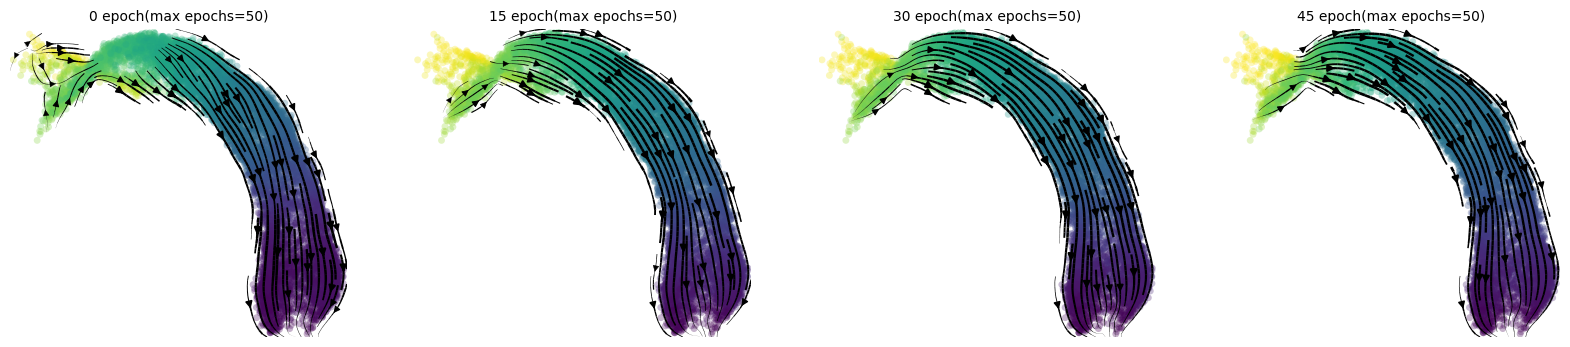

In [8]:
n = len(epoch_list)
fig, ax = velovgi.pl.calc_fig(n)
for i in range(n):
    name = name_list[i]
    tmp_adata = adata_list[i]
    scv.tl.velocity_graph(tmp_adata) # 转移矩阵计算
    scv.tl.velocity_pseudotime(tmp_adata) # 速率的伪时间计算
    scv.pl.velocity_embedding_stream(tmp_adata, color="velocity_pseudotime", ax=ax[i], title=name, show=False, colorbar=False)

3. 绘制基因速率图

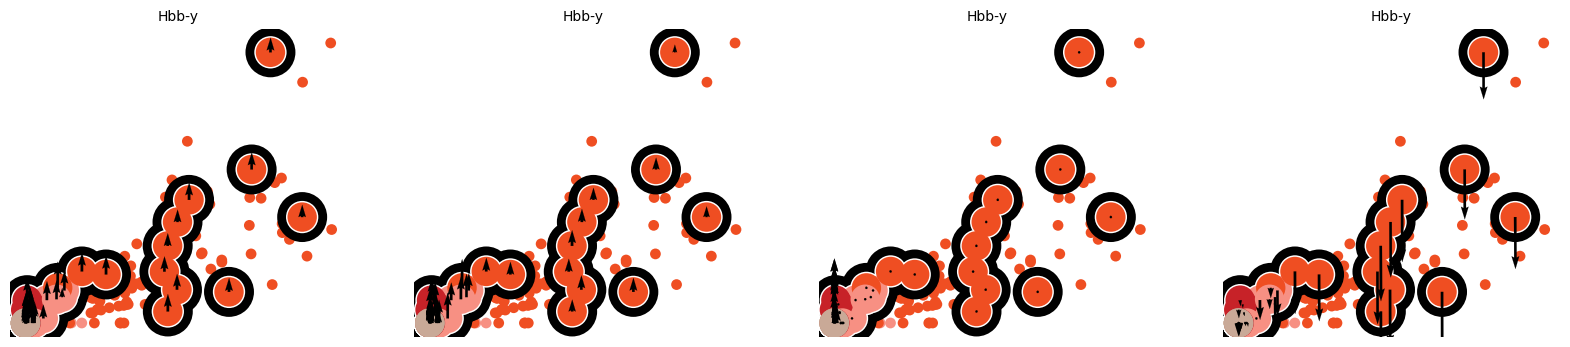

In [ ]:
import math
import numpy as np
from scvelo.pl.utils import default_size

gene_list = ["Hbb-y"]

np.random.seed(0)
cell_num = adata.shape[0]
size = default_size(adata)*math.log(adata.shape[0]) # 箭头的缩放比例
index_list = np.random.choice(np.arange(cell_num), size=int(cell_num*0.1), replace=False) # 部分细胞展示速率图


for gene in gene_list:
    item_figsize = (5, 4) # 单张图的figsize
    fig, ax = velovgi.pl.calc_fig(n, item_figsize=item_figsize) # 计算尺寸
    for i in range(n):
        name = name_list[i]
        adata = adata_list[i]
        tmp_adata = adata[index_list, gene_list]
        velovgi.pl.draw_velocity_gene(tmp_adata, adata, gene, cluster_key=cluster_key, size=size, ax=ax[i])